# [ Introduction](Introduction.ipynb)

# [ Données météorologiques](Donnes_meteo.ipynb)

# [ Modèle Thermique et modèle mathematique](Modele_thermique.ipynb)

# [Implementation et resultats : simulation stationnaire, polystrène expansé ](Stationnaire_cas.ipynb)

# [ Implementation et resultats : simulation stationnaire, laine de mouton ](laine.ipynb)

# [ Estimation degre-heures](degre-hours.ipynb)

# [ Modèle Mathematique, implementation et resultats : simulation stationnaire à répresetation état-spatiel ](state-space.ipynb)

# [ Simulation dynamique ](simulation_dynamique.ipynb)

# Changer entre modèles 

Cette section utilise différents modèles de fonctionnement du système HAVC pour comparer la consommation en l'intégrant sur une période de temps.

σ = 5.67e-08 W/(m²⋅K⁴)


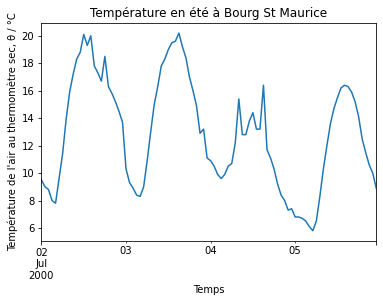

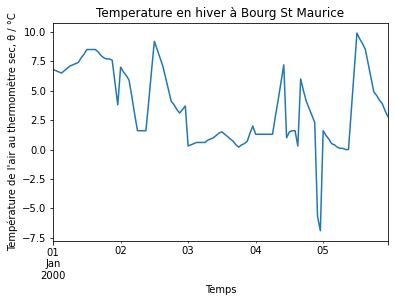

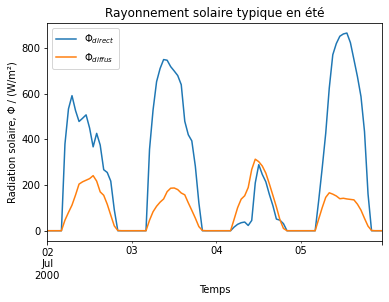

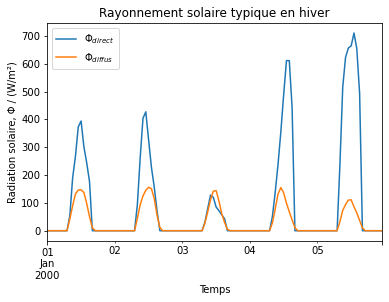

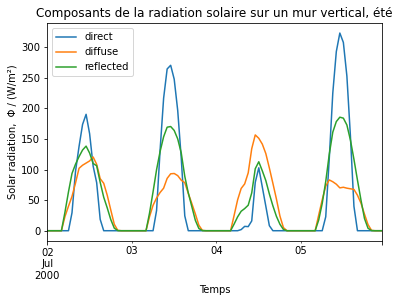

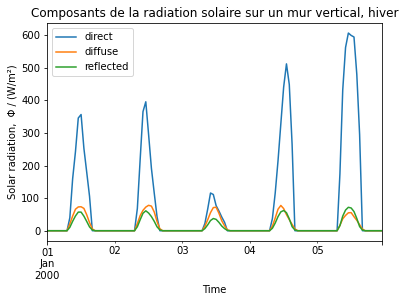

b =  [10.  0.  0.  0.  0.  0.  0.  0. 10.  0. 10. 20.]
f =  [1. 0. 0. 0. 1. 0. 1. 1.]
y =  [0. 0. 0. 0. 0. 0. 1. 0.]
θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C
u = [10 10 10 20  0  0  0  0]
yss = [10.] °C
Max error between DAE and state-space: 0.00e+00 °C
Time constants:
['929.81 s', '3577.24 s', '8547.20 s', '44267.74 s']

2 x Time constants:
['1859.62 s', '7154.49 s', '17094.40 s', '88535.48 s']

Maximum time step: 1859.62 s = 30.99 min
dt = 480 s = 8 min
4 * Time constants: 
 [  3716  14308  34188 177068] s 

Settling time: 177071 s = 2951.2 min = 49.19 h = 2.05 days
Duration = 180000.0 s
Number of time steps = 375


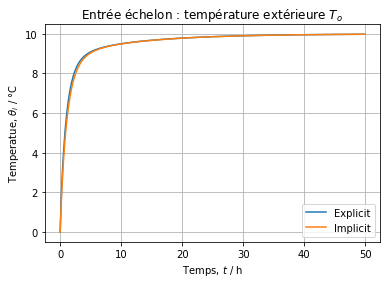

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 9.9814 °C
2000-01-01 12:00:00 	start date
2000-01-07 18:00:00 	end date


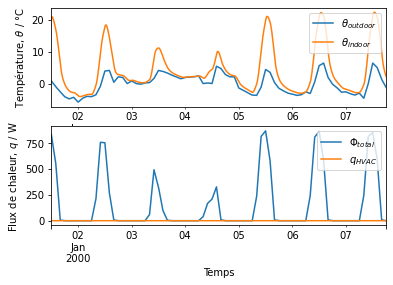

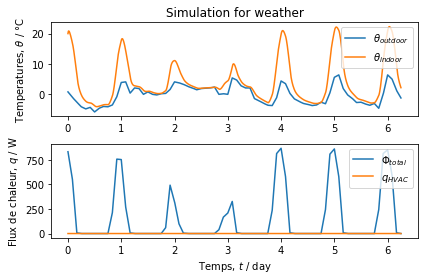

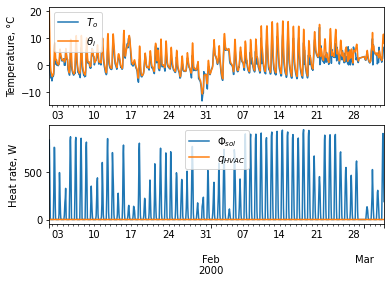

Maximum time step: 730.10 s
dt = 50 s


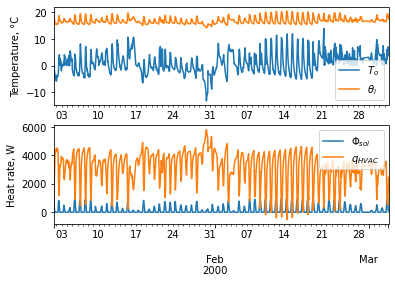

In [1]:
%run "simulation_dynamique.ipynb"

In [2]:
Tisp = 20   # indoor setpoint temperature, °C
Δθ = 5      # temperature deadband, °C

## Modèle sans apports d'énergie du système HVAC

Le bâtiment est en marche libre (la température intérieure flotte librement) si le régulateur P n'est pas efficace, c'est-à-dire $K_p \rightarrow 0$.

In [3]:
Kpf = 1e-3   # no controller Kp -> 0
TCa = tuto.thermal_circuit(Kpf)
[Af, Bf, Cf, Df] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['C'], TCa['b'], TCa['f'], TCa['y'])
dt_max = min(-2. / np.linalg.eig(Af)[0])
print(f'Maximum time step in free-floating is {dt_max:.2f} s')

Maximum time step in free-floating is 2673.61 s


In [4]:
def P_control(filename, start_date, end_date, dt,
              As, Bs, Cs, Ds, Kp, Tisp):
    t, u, data = tuto.inputs(filename, start_date, end_date, dt, Tisp)

    # Initialize temperature vector
    θ = np.full([As.shape[0], u.shape[0]], np.inf)
    θ[:, 0] = Tisp * np.ones(As.shape[0])

    I = np.eye(As.shape[0])

    # Simulation in time
    for k in range(u.shape[0] - 1):
        θ[:, k + 1] = (I + dt * As) @ θ[:, k]\
            + dt * Bs @ u.iloc[k, :]
    # Indoor temperature
    y = Cs @ θ + Ds @ u.to_numpy().T
    y = y.T
    # HVAC heat flow
    q_HVAC = Kp * (data['Ti'] - y[:, 0])

    # Plot results
    return y, q_HVAC, data

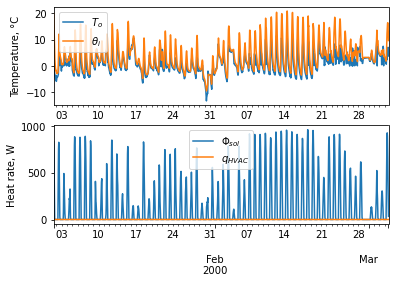

In [5]:
dt = 360   # time step, s
y, q_HVAC, data = P_control(
    filename, start_date, end_date, dt,
    Af, Bf, Cf, Df, Kpf, Tisp)
tuto.plot_results(y, q_HVAC, data)

Comme le bâtiment fonctionne en régime libre, la consommation d'énergie pour le chauffage, la ventilation et la climatisation est nulle, $Q_{HVAC} = 0 \text{ J}$.

In [6]:
print(f"Q_HVAC = {dt * sum(abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 0.0 kW·h


## Modèle avec un contrôleur parfait

Un contrôleur proportionnel "parfait" aurait un gain infini, $K_p \rightarrow \infty$. La modification du gain du contrôleur implique une modification du pas de temps maximum. Ce système est considéré comme un système de refroidissement et de chauffage en même temps si la température de consigne varie, bien qu'il ne s'agisse pas d'une opération logique ou idéal, ce modèle sera modifié dans les systèmes analysés suivants.

In [7]:
Kpc = 1e3   # perfect controller Kp -> ∞
TCa = tuto.thermal_circuit(Kpc)
[Ac, Bc, Cc, Dc] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['C'], TCa['b'], TCa['f'], TCa['y'])
dt_max = min(-2. / np.linalg.eig(Ac)[0])
print(f'For Kp = {Kpc:.0e}, the maximum time step is {dt_max:.0f} s')

For Kp = 1e+03, the maximum time step is 730 s


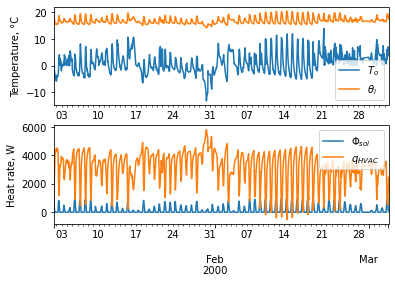

In [8]:
dt = 50     # time step, s
y, q_HVAC, data = P_control(
    filename, start_date, end_date, dt,
    Ac, Bc, Cc, Dc, Kpc, Tisp)
tuto.plot_results(y, q_HVAC, data)

In [9]:
print(f"Q_HVAC = {dt * sum(abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 4789.8 kW·h


## Modèle pour chauffage et climatisation

Maintenir la température intérieure à un niveau constant n'est pas efficace sur le plan énergétique. Il est préférable d'avoir une zone morte pour la température intérieure lorsque le bâtiment est en fonctionnement libre et d'utiliser le système CVC lorsque la température intérieure est en dehors de la zone morte.

Une approche pour la simulation du chauffage et du refroidissement avec une zone morte consiste à utiliser les deux modèles, le fonctionnement libre et le contrôle parfait. Dans ce cas, le pas de temps est le minimum entre les deux.

In [10]:
def switch_models(filename, start_date, end_date, dt,
                  Af, Bf, Cf, Df, Kpf,
                  Ac, Bc, Cc, Dc, Kpc,
                  Tisp, DeltaT):
    
    t, u, data = tuto.inputs(filename, start_date, end_date, dt, Tisp)

    # initial values for temperatures
    temp_exp = 0 * np.ones([Af.shape[0], u.shape[0]])
    Tisp = Tisp * np.ones(u.shape[0])
    y = np.zeros(u.shape[0])
    y[0] = Tisp[0]
    q_HVAC = 0 * np.ones(u.shape[0])

    # integration in time
    I = np.eye(Af.shape[0])
    for k in range(u.shape[0] - 1):
        if y[k] < Tisp[k] or y[k] > DeltaT + Tisp[k]:
            temp_exp[:, k + 1] = (I + dt * Ac) @ temp_exp[:, k]\
                + dt * Bc @ u.iloc[k, :]
            y[k + 1] = Cc @ temp_exp[:, k + 1] + Dc @ u.iloc[k + 1]
            q_HVAC[k + 1] = Kpc * (Tisp[k + 1] - y[k + 1])
        else:
            temp_exp[:, k + 1] = (I + dt * Af) @ temp_exp[:, k]\
                + dt * Bf @ u.iloc[k, :]
            y[k + 1] = Cf @ temp_exp[:, k + 1] + Df @ u.iloc[k]
            q_HVAC[k + 1] = 0
    return y, q_HVAC, data 

Pour la température interieur fixé et une bande de température

In [11]:
θ_isp = 20  # indoor temperature setpoint, °C
Δθ = 2.5    # deadband of indoor temperature, °C

### Gran gain pour le contrôleur 

(0.0, 2000.0)

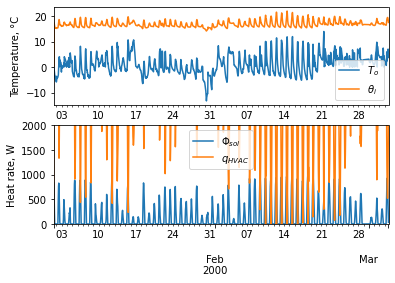

In [12]:
dt = 50
Kpc = 1e3   # no controller Kp -> 0

TCa = tuto.thermal_circuit(Kpc)
[Ac, Bc, Cc, Dc] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['C'], TCa['b'], TCa['f'], TCa['y'])

y, q_HVAC, data = switch_models(
    filename, start_date, end_date, dt,
    Af, Bf, Cf, Df, Kpf,
    Ac, Bc, Cc, Dc, Kpc,
    Tisp, Δθ)

tuto.plot_results(y, q_HVAC, data)
ax = plt.gca()
ax.set_ylim([0, 2000])

In [13]:
print(f"Q_HVAC = {dt * sum(abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 4801.3 kW·h


### Gain proportionnel important pour le contrôleur avec un pas de temps réduit

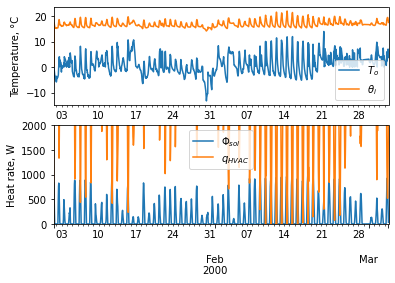

In [14]:
dt = 25
Kpc = 1e3   # no controller Kp -> 0

TCa = tuto.thermal_circuit(Kpc)
[Ac, Bc, Cc, Dc] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['C'], TCa['b'], TCa['f'], TCa['y'])
y, q_HVAC, data = switch_models(
    filename, start_date, end_date, dt,
    Af, Bf, Cf, Df, Kpf,
    Ac, Bc, Cc, Dc, Kpc,
    Tisp, Δθ)
tuto.plot_results(y, q_HVAC, data)
ax = plt.gca()
ax.set_ylim([0, 2000]);

In [15]:
print(f"Q_HVAC = {dt * sum(abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 4801.5 kW·h


### Gain optimal du contrôleur

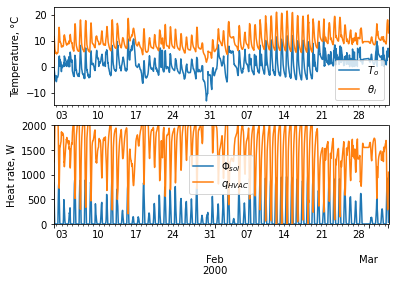

In [16]:
dt = 50     # time step, s
Kpc = 1.5e2 # controller Kp

TCa = tuto.thermal_circuit(Kpc)
[Ac, Bc, Cc, Dc] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['C'], TCa['b'], TCa['f'], TCa['y'])
y, q_HVAC, data = switch_models(
    filename, start_date, end_date, dt,
    Af, Bf, Cf, Df, Kpf,
    Ac, Bc, Cc, Dc, Kpc,
    Tisp, Δθ)
tuto.plot_results(y, q_HVAC, data)
ax = plt.gca()
ax.set_ylim([0, 2000]);

In [17]:
print(f"Q_HVAC = {sum(dt * abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 2281.3 kW·h


## Chauffage seul

S'il n'y a que du chauffage, le système HVAC contrôle la température intérieure lorsqu'elle est inférieure au point de consigne et laisse le bâtiment en marche libre si la température intérieure est supérieure au point de consigne.

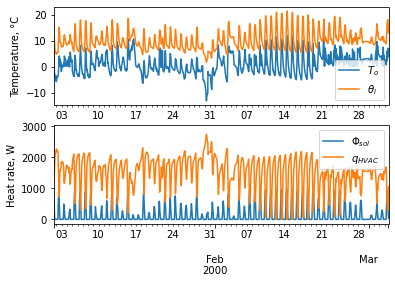

In [18]:
t, u, data = tuto.inputs(filename, start_date, end_date, dt, Tisp)

# initial values for temperatures
temp_exp = 0 * np.ones([Af.shape[0], u.shape[0]])
Tisp = Tisp * np.ones(u.shape[0])
y = np.zeros(u.shape[0])
y[0] = Tisp[0]
q_HVAC = 0 * np.ones(u.shape[0])

I = np.eye(Af.shape[0])
for k in range(u.shape[0] - 1):
    if y[k] < data['Ti'][k]:
        temp_exp[:, k + 1] = (I + dt * Ac) @ temp_exp[:, k]\
            + dt * Bc @ u.iloc[k, :]
        y[k + 1] = Cc @ temp_exp[:, k + 1] + Dc @ u.iloc[k]
        q_HVAC[k + 1] = Kpc * (data['Ti'][k + 1] - y[k + 1])
    else:
        temp_exp[:, k + 1] = (I + dt * Af) @ temp_exp[:, k]\
            + dt * Bf @ u.iloc[k, :]
        y[k + 1] = Cf @ temp_exp[:, k + 1] + Df @ u.iloc[k]
        q_HVAC[k + 1] = 0

tuto.plot_results(y, q_HVAC, data)

In [19]:
print(f"Q_HVAC = {dt * sum(abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 2281.3 kW·h


Ce dernier système est le plus efficace et le plus logique car, dans la saison d'utilisation du chauffage, la climatisation n'est pas utilisée lorsque la température intérieure souhaitée change (augmente de plus de 20° dans ce cas), mais plutôt, le flux de chaleur vers le bâtiment diminue ou est nul, jusqu'à ce que la température intérieure tombe au-delà de la limite minimale souhaitée.


---

# Conclusion

Dans le cadre de ce projet, la consommation d'un bâtiment a été analysée en simulant sa géométrie. L'objectif était de caractériser la consommation d'énergie potentielle et les différentes options de matériaux pour l'isolation de l'enveloppe. En analysant les deux types d'isolation : le polystyrène extrudé et la laine de chanvre, une consommation légèrement plus élevée du matériau de chanvre a été observée, mais la différence est faible et si l'on considère les avantages de l'utilisation d'un producteur local du matériau d'isolation, les réductions de l'impact environnemental peuvent être significatives et compenser la différence de consommation d'énergie. Pour le vérifier, une analyse du cycle de vie sera réalisée afin d'évaluer le véritable impact global d'un matériau par rapport à l'autre. 
D'autre part, l'estimation de la consommation d'énergie au moyen d'utilitaires tels que python a été très interactive car il a été possible de comprendre pleinement les systèmes de transfert de chaleur qui sont couramment utilisés pour les simulations de consommation d'énergie dans les bâtiments, cependant, ces outils de simulation logique sont toujours pertinents car ils sont plus statistiques et prennent en compte plus de paramètres qui peuvent être compliqués à mettre en œuvre en python.